# whole_system_stage1

語意分割與crop

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("E:/together/tiffany/Mask_RCNN-master")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
#BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

Using TensorFlow backend.


## Configurations

In [2]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "samples\\nucleus_crop\\datasets")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0 #7/3解決No instances to display
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.004
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 28
Classes: ['BG', 'balloon']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
#weights_path = "E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\mask_rcnn_nucleus_0040.h5"
weights_path = "E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\mask_rcnn_nucleus_new_0030.h5"


# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  E:\together\tiffany\Mask_RCNN-master\samples\nucleus_crop\mask_rcnn_nucleus_new_0030.h5


## Run Detection

E:\together\tiffany\Mask_RCNN-master\samples\nucleus_crop\datasets\ANA_special\PC110046.JPG
Processing 1 images
image                    shape: (2352, 3136, 3)       min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  118.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 3136.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


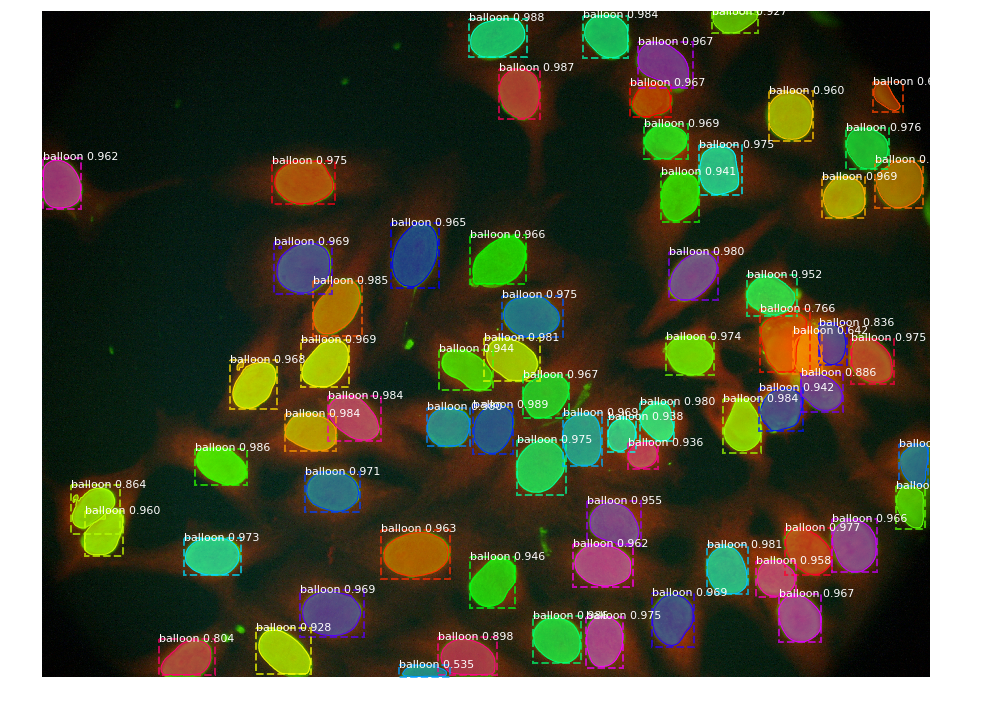

In [16]:
#測試一張照片
import skimage.io
#IMAGE_DIR="E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\datasets\\ANA_picked\\Peripheral"
#IMAGE_DIR="E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\datasets\\ANA_test\\Peripheral"
IMAGE_DIR="E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\datasets\\ANA_special"
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
random_photo=random.choice(file_names)
image = skimage.io.imread(os.path.join(IMAGE_DIR, random_photo))

#上方隨機選的圖片之檔案位置
print(IMAGE_DIR + "\\" + random_photo)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])

In [45]:
#CROP一次多張


from PIL import Image

#叫出上方隨機挑選的圖片
im = Image.open(IMAGE_DIR + "\\" + random_photo)
#承上隨機選的圖片之檔案位置來進行切割
print(IMAGE_DIR + "\\" + random_photo)

#叫出指定圖片
#im = Image.open("E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\datasets\\ANA_test\\P5037526.JPG")



"""
a=r['rois'][0][0] #y1
b=r['rois'][0][1] #x1
c=r['rois'][0][2] #y2
d=r['rois'][0][3] #x2
"""



for i in range(0, len(r['scores'])):
        
    region = im.crop((r['rois'][i][1], r['rois'][i][0], r['rois'][i][3], r['rois'][i][2])) #crop(x1,y1,x2,y2) -->(x1,y1)為左上角座標 (x2,y2)為右下角座標<即寬長>
    name = str(i) + ".jpeg"
    #region.save(name)
    
    #裁減出來的圖片存入指定資料夾
    path_save="E:\\together\\tiffany\\Mask_RCNN-master\\samples\\nucleus_crop\\datasets\\ANA_test_crop_datas"
    region.save(os.path.join(path_save,name))
    

E:\together\tiffany\Mask_RCNN-master\samples\nucleus_crop\datasets\ANA_special\P5031066.JPG


In [1]:
#print(r['rois'])

#print(r['rois'][0][0])
#print(r['rois'][1][0])
#print(r['scores'])
#len(r['scores']) #測出來的數量 #若只有一個遮罩會出現問題

## ----------------------------------- 分隔線

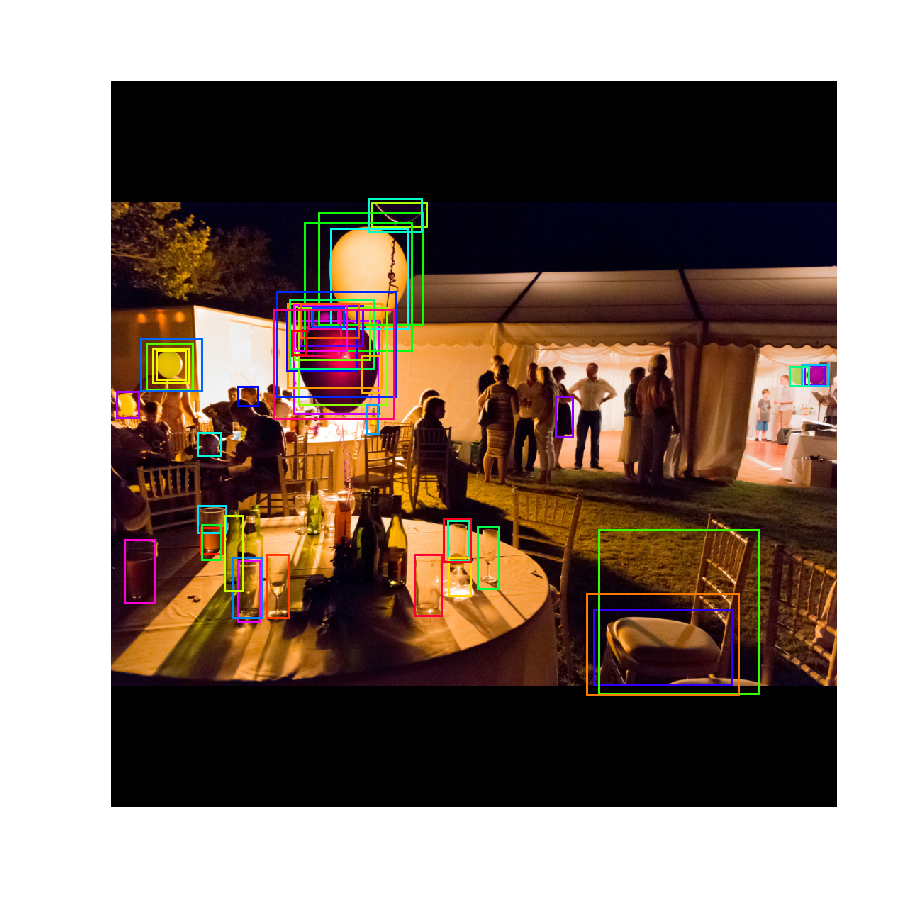

In [16]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

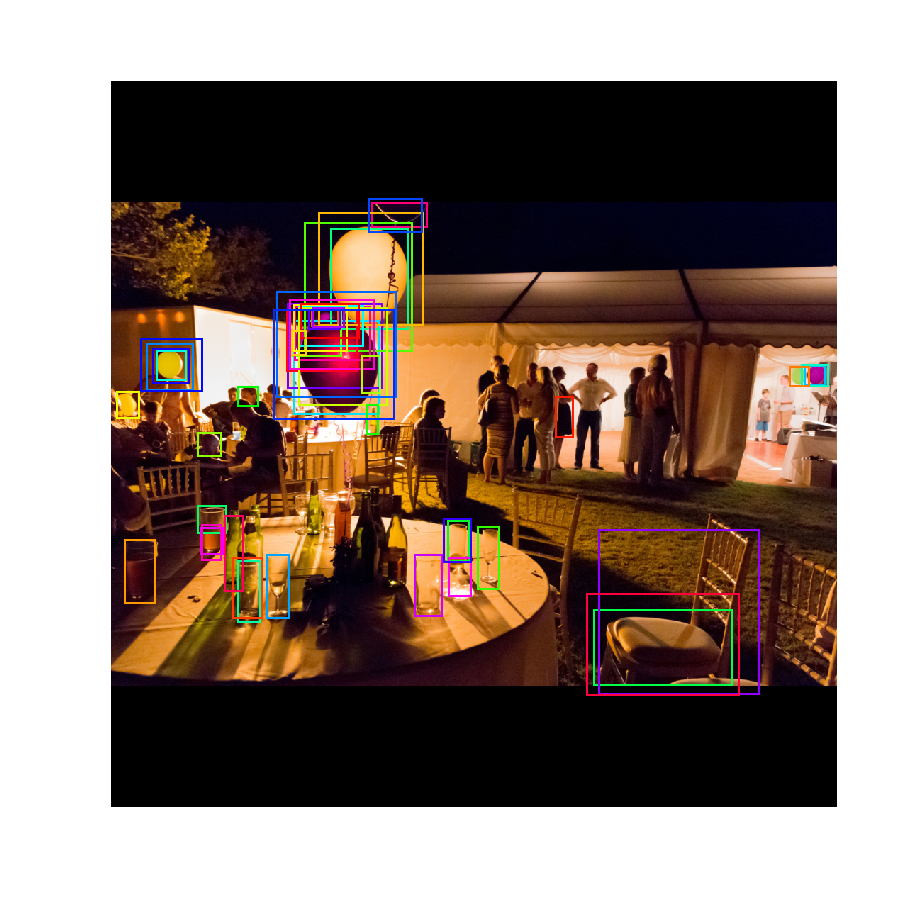

In [17]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [18]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 2, 4)       min:   -5.36603  max:    3.75144
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000
detections               shape: (1, 100, 6)           min:    0.00000  max: 1010.00000


4 detections: ['balloon' 'balloon' 'balloon' 'balloon']


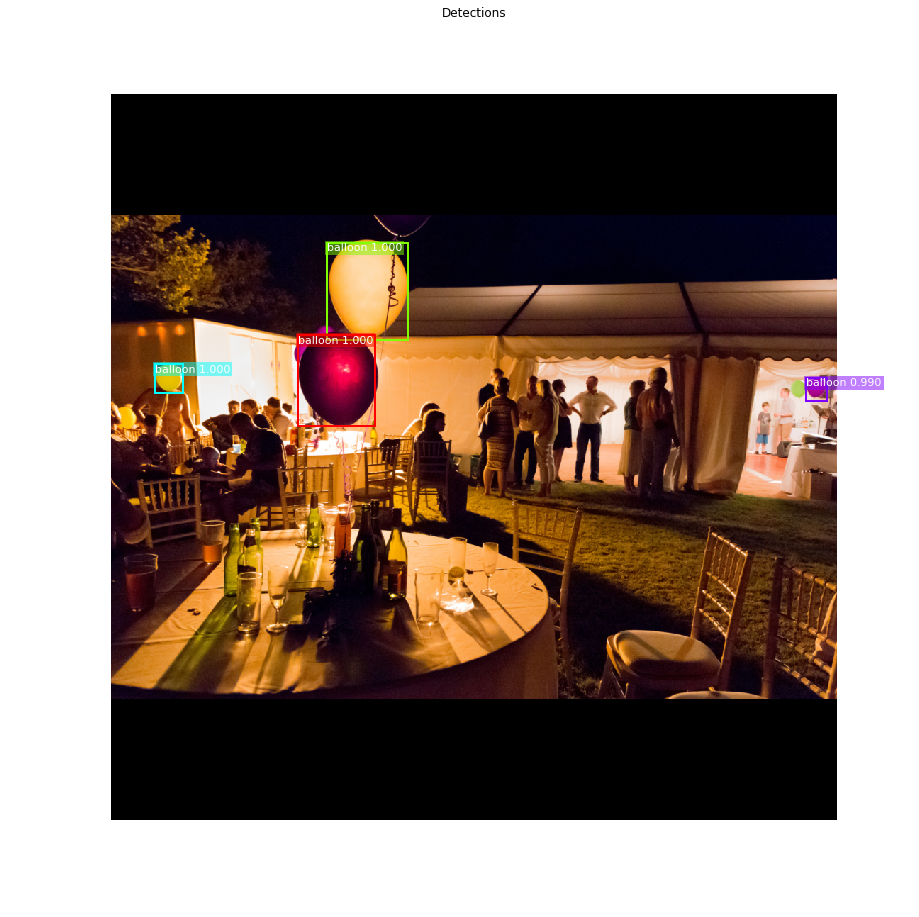

In [19]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [20]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
24 Positive ROIs
[('BG', 976), ('balloon', 24)]
